# Flower Classification Through Transfer Learning

- Tasks
  - Predict & Clf metrics
    - Predict then show the result images
    - Add evaluation metrics for predictions
    - Visualization of the metrics
    - Classification metrics
  - Modelling
    - Add phases as chapter
      - Basic modelling
      - Tranfer Learning
        - Implement All the state of art models
      - Fine tuning
        - Configurating the State of art models layers (Use Fine tuning guides respectly the used model)

### (A) Dependencies

In [189]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [190]:
# Declerating the configuration params
AUTOTUNE = tf.data.experimental.AUTOTUNE


tb_log_dir = './logs'


batch_size=32
img_resize = (224, 224)
img_size = img_resize + (3,)

### (B) Data

#### Downloading and Loading the dataset

In [191]:
# Load the TensorFlow Flowers dataset
dataset, info = tfds.load('tf_flowers', split='train[:80%]', as_supervised=True, with_info=True)

#### Extracting the basic infos

In [192]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [193]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

#### Class Distributions

In [ ]:
# Count the number of images in each class
num_images = [0] * len(class_names)
for images, label in dataset.take(len(dataset)):
    num_images[label] += 1

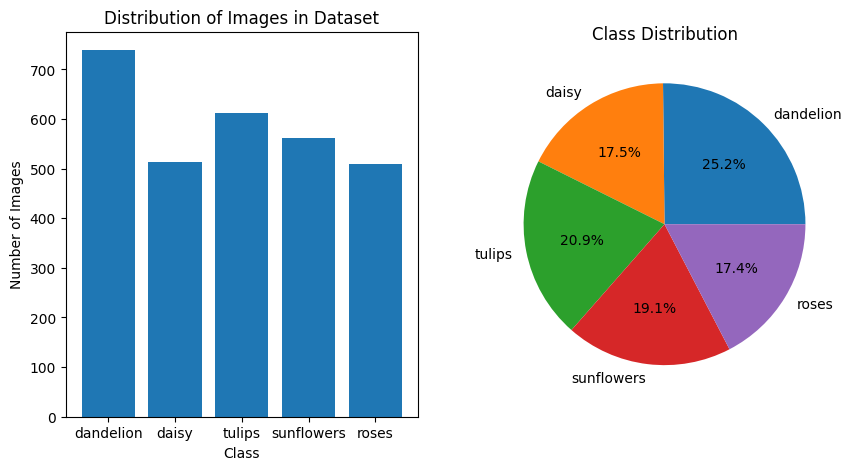

In [107]:
# setting the image size
plt.figure(figsize=(10,5))

# Plot a bar chart of the distribution of images in each class
plt.subplot(1,2,1)
plt.bar(class_names, num_images)
plt.title('Distribution of Images in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Create pie chart
plt.subplot(1,2,2)
plt.pie(num_images, labels=class_names, autopct='%1.1f%%')
plt.title('Class Distribution')

plt.show()

#### Dataset Split

In [194]:
def split_dataset(dataset, train_split=0.6, val_split=0.2, shuffle_buffer_size=1024):
    # Shuffling for randomless
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    
    # extracting the dataset info
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    test_size = dataset_size - train_size - val_size


    # Dataset splits
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)


    return train_dataset, val_dataset, test_dataset


In [195]:
train_ds, val_ds, test_ds = split_dataset(dataset)

### (C) Preprocessing

#### Plotting the images

In [196]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [197]:
def decode_the_label(encoding_index, encoding=class_names):
    class_name =  encoding[encoding_index]
    return class_name

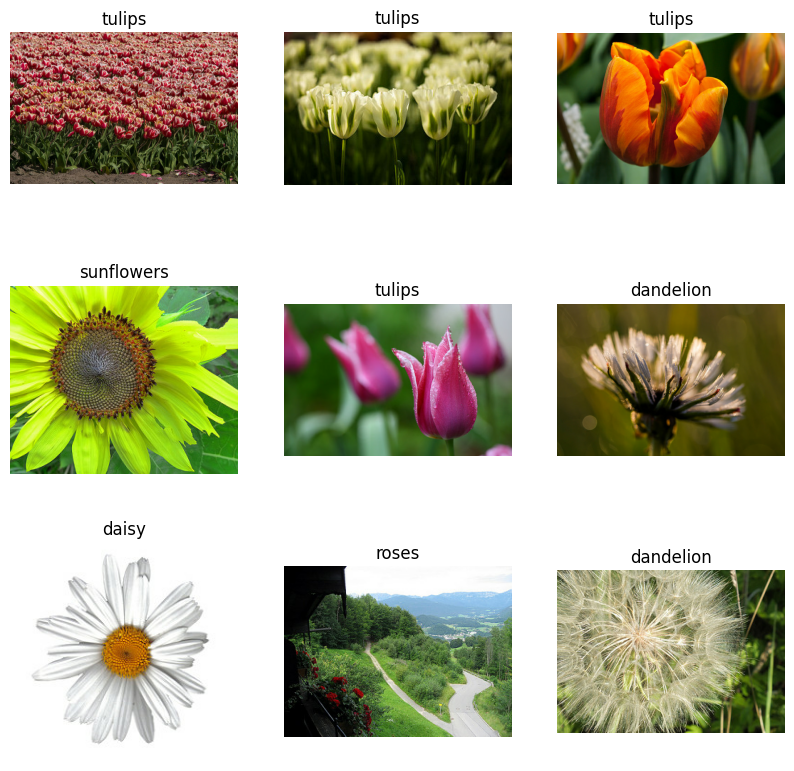

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label_decoded_id) in enumerate(train_ds.take(9)):
  
  # finding out corresponding class name
  c = decode_the_label(encoding_index= int(label_decoded_id) )
  img_shape = images[i].numpy().shape

  if c == "dandelion": cv2.imwrite("dandelion.png",np.array(image)[...,::-1])

  # plotting the image
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title(c)
  plt.axis("off")

plt.show()

#### Pre-processing the dataset

In [198]:
def process_image(image, label):
    # Cast the image to tf.float32
    image = tf.cast(image, tf.float32)
    
    # Resize the image to img_resize
    image = tf.image.resize(image, img_resize)
    
    # Normalize the image
    image /= 255.0
    
    # Return the processed image and label
    return image, label


In [199]:
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)
test_ds = test_ds.map(process_image)

#### Data Augmentation

##### Declerating the Augmentation Process

In [200]:
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)


# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            # JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            # RandomContrast(limit=0.2, p=0.5),
            #HorizontalFlip(),
        ])


def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    #aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=img_size)
    return aug_img


def image_augment(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label


/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [201]:
from functools import partial
train_ds = train_ds.map(partial(image_augment, img_size=img_resize),num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


```python
def set_shapes(img, label, img_shape=img_size):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label
```

```python
train_ds = train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
```

```python
"""
train_ds = train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)#.batch(32).prefetch(AUTOTUNE)
val_ds = val_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)#.batch(32).prefetch(AUTOTUNE)
test_ds = test_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)#.batch(32).prefetch(AUTOTUNE)
"""
```

##### Plotting the example augmentations

In [202]:
img_resize

(224, 224)

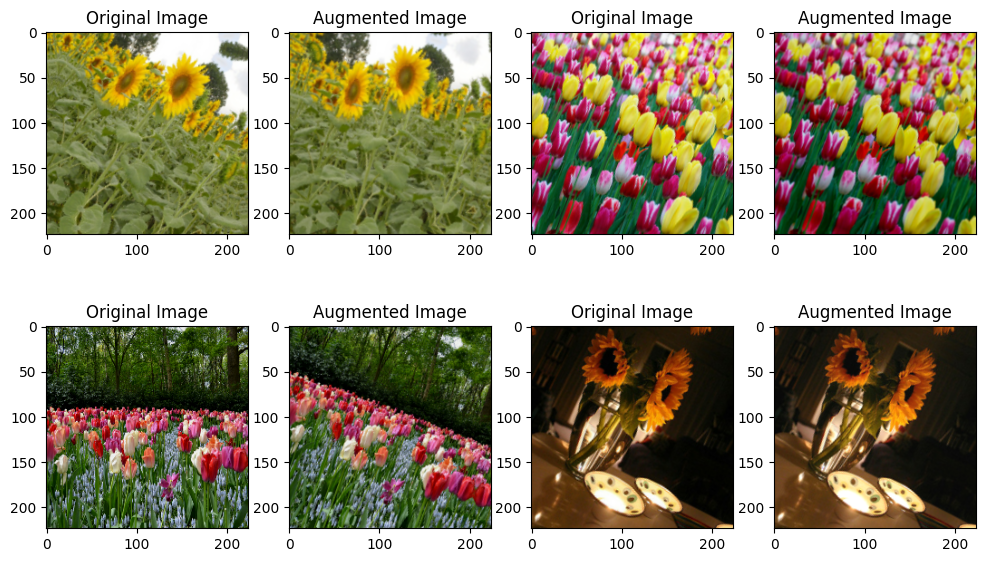

In [178]:
from itertools import count
plt.figure(figsize=(12,7))
for i, (img,label) in zip(count(step=2),train_ds.take(4)):
    # Apply the augmentations to the image
    aug_img = aug_fn(np.array(img), img_size=img_resize)

    # Plot the original and augmented images side-by-side
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title("Original Image")
    
    plt.subplot(2, 4, i+2)
    plt.imshow(aug_img)
    plt.title("Augmented Image")

#### Dataset Optimization Config

In [203]:
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

### (D) Modelling

#### Base Model

In [13]:
# Load a pre-trained model
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


#### Architectures

- Architectures
  - Classic Convolutional Neural Network (CNN) based models:
    - LeNet-5
    - AlexNet
    - ZFNet
    - VGGNet
    - ResNet
    - InceptionNet
    - Xception
  - Residual Network (ResNet) based models:
    - ResNet
    - ResNeXt
    - DenseNet
  - Attention-based models:
    - SE-Net
    - CBAM-Net
    - Non-local Neural Networks
  - Lightweight models:
    - MobileNet
    - ShuffleNet
    - EfficientNet
    - MnasNet
  - Object Detection models:
    - YOLO (You Only Look Once)
    - SSD (Single Shot MultiBox Detector)
    - Faster R-CNN
    - Mask R-CNN

Sequential Model
```python
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

```

Functional Model
```python
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

```

##### Creating the Architecture

In [14]:
# Add a custom head on top of the base model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##### Base Model Architecture Plotting

In [151]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

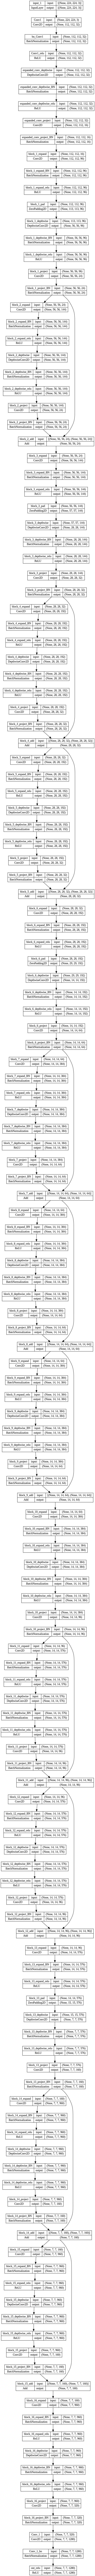

In [155]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

##### Classifier Architecture Plotting

In [153]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


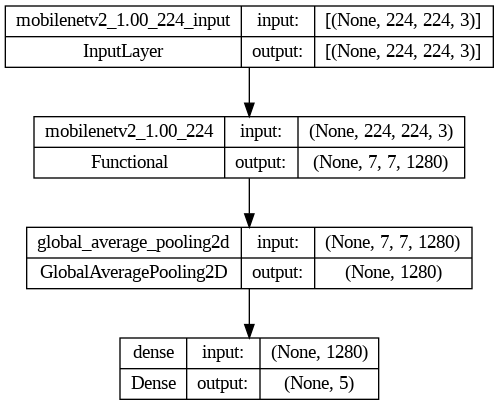

In [154]:
tf.keras.utils.plot_model(model, show_shapes=True)

#### Callbacks

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))

# Temporary save paths
checkpoint_path = "TemporaryModel_ModelCheckpoint.h5"
tb_log_dir = "./logs"

In [16]:
callbacks = [
    LearningRateScheduler(step_decay),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, verbose=1),
    CSVLogger(filename='training.log'),
    LambdaCallback(on_epoch_end=print_current_lr)
]

#### Training

In [17]:
# Train the model
history = model.fit(train_ds, validation_data = val_ds, callbacks=callbacks, epochs=150)

Epoch 1/150
56/56 [==============================] - ETA: 0s - loss: 5.8655 - accuracy: 0.7217
Epoch 1: val_loss improved from inf to 2.77105, saving model to TemporaryModel_ModelCheckpoint.h5
Learning rate in epoch 0 is 0.10000000149011612
56/56 [==============================] - 166s 3s/step - loss: 5.8655 - accuracy: 0.7217 - val_loss: 2.7710 - val_accuracy: 0.8450 - lr: 0.1000
Epoch 2/150
55/56 [============================>.] - ETA: 2s - loss: 3.6677 - accuracy: 0.8307
Epoch 2: val_loss did not improve from 2.77105
Learning rate in epoch 1 is 0.10000000149011612
56/56 [==============================] - 153s 3s/step - loss: 3.6656 - accuracy: 0.8308 - val_loss: 2.9135 - val_accuracy: 0.8518 - lr: 0.1000
Epoch 3/150
55/56 [============================>.] - ETA: 1s - loss: 2.6655 - accuracy: 0.8534
Epoch 3: val_loss improved from 2.77105 to 2.74946, saving model to TemporaryModel_ModelCheckpoint.h5
Learning rate in epoch 2 is 0.10000000149011612
56/56 [==============================]

#### Visualiting Training History

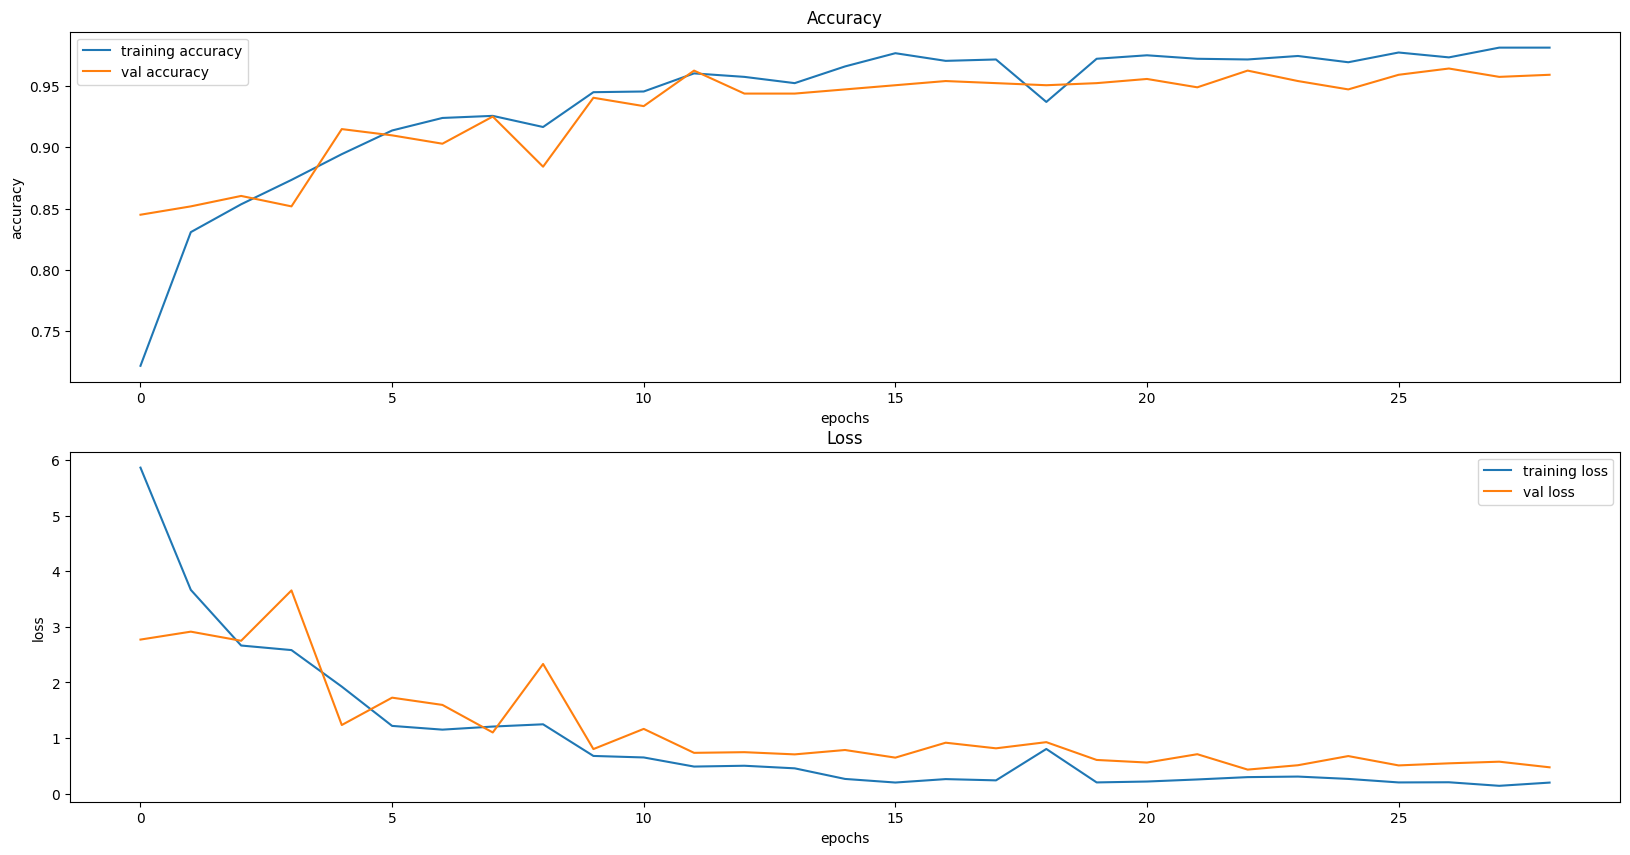

In [18]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#### Predicting

##### Inferencing

In [63]:
# extracting predictions classes
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

19/19 [==============================] - 29s 1s/step


In [ ]:
# Make predictions on the test dataset
y_true,y_pred = [], []
for images, labels in test_ds:
    # prediction
    predictions = model.predict(images)
    
    # extracting the actual and predicted labels
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 392ms/step


##### Evaluations

In [229]:
# Evaluating
val_eval = model.evaluate(val_ds)
test_eval = model.evaluate(test_ds)

19/19 [==============================] - 25s 1s/step - loss: 0.7845 - accuracy: 0.9490


In [230]:
val_eval

[0.5097076892852783, 0.9540033936500549]

In [231]:
test_eval

[0.7844754457473755, 0.9489796161651611]

##### Plotting the predictions

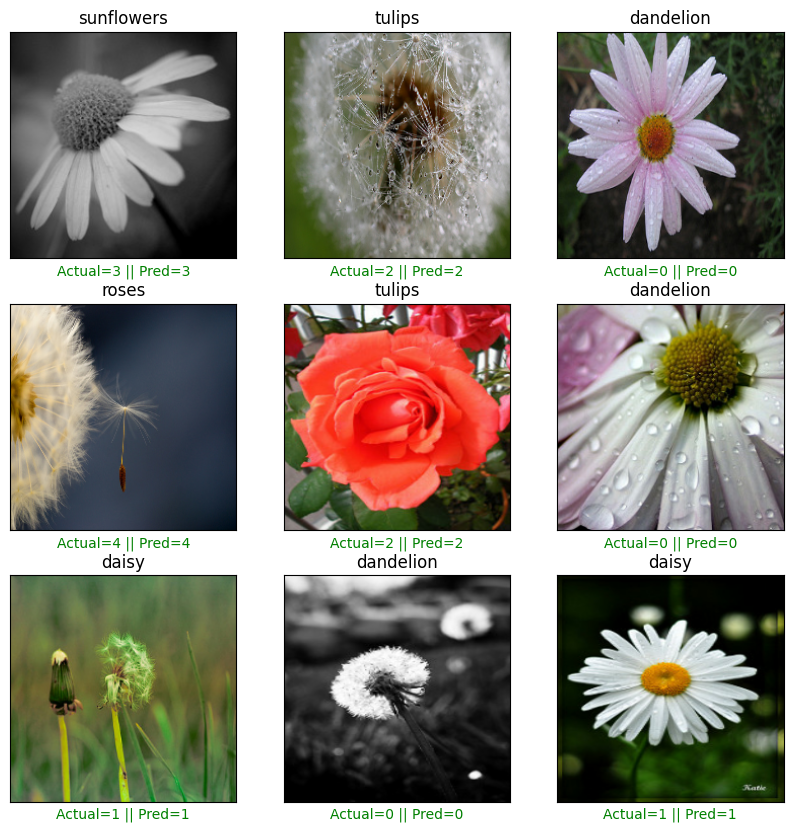

In [233]:
# plottings 
plt.figure(figsize = (10, 10))

# Getting the initial params
image_size = 9
test_images = [image for image, label in test_ds.unbatch().take(image_size)]

# plotting the predictions
for i in range(9):
    
    # creating a figure
    plt.subplot(3, 3, i + 1)
    
    # removing unnessesary plotting components for an image
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # getting the image 
    prediction = y_true[i]
    actual = y_pred[i]
    
    # coloring the label of the image according to result
    col = 'r' if prediction != actual else 'g'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)

    # Writing the name of the class
    title = decode_the_label(actual)
    plt.title(title)

    # plotting the image
    plt.imshow(test_images[i])
plt.show()

#### Extracting the metric reports

In [ ]:
from sklearn.metrics import classification_report

# Get the classification report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   dandelion       0.99      0.94      0.96       156
       daisy       0.95      0.93      0.94       117
      tulips       0.93      0.93      0.93       107
  sunflowers       0.92      0.99      0.96       111
       roses       0.94      0.96      0.95        97

    accuracy                           0.95       588
   macro avg       0.95      0.95      0.95       588
weighted avg       0.95      0.95      0.95       588



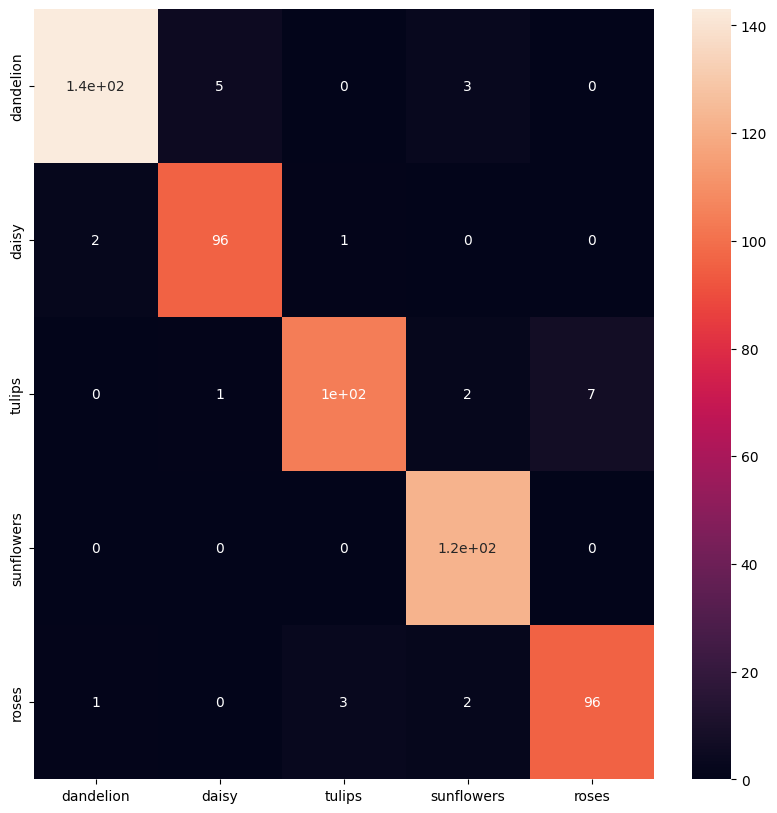

In [232]:
# confusion matrix
import seaborn as sns
import pandas as pd

from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_true, y_pred)


# data casting
df_cm = pd.DataFrame(cf, index = class_names,  columns = class_names)

#plotting the confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True);

### (E) Model Saving

#### Save the best model

In [19]:
# Load the best weights
model.load_weights(checkpoint_path)

# best_model = tf.keras.models.load_model('saved_model/my_model') # best_model_save_path

In [20]:
from datetime import datetime


now = datetime.now().strftime("%m-%d-%Y_%H:%M:%S")
best_model_save_path = f"{model.name}" #_{now}" 


model.save(best_model_save_path)

In [28]:
best_model_save_path

'sequential'

#### Downloading the models

##### Select the model path

In [21]:
model_path = best_model_save_path
all_models = best_model_save_path #"/content/Models"
best_model_save_path

'sequential'

##### Zip the model

###### Alternative Zipping -1 

```python
import os, shutil
zipped_dir = all_models
shutil.make_archive(zipped_dir, 'zip', ".")
```

###### Alternative Zipping - 2
```python
# Zipping via Bash code, if shutil didn't work
!zip -r "/content/model.zip" "/content/Model"

# Copy the file into google drive
!cp -rv '/content/file.zip' '/content/drive/MyDrive/Home'

# Download the model into your local
from google.colab import files
files.download('/content/file.zip')
```

In [23]:
from google.colab import drive, files
import os

# Connecting the drive
#drive.mount('/gdrive')

In [24]:
dst, src = f"{best_model_save_path}.zip", best_model_save_path
#dst_g_disk = "/content/drive/MyDrive/Home"

In [25]:
# Zipping the model to download
os.system(f"zip -r {dst} {src}")

0

In [26]:
# Copying the zipped model into google drive
#os.system(f"cp -rv {dst} {dst_g_disk}")

##### Download the zipped file into the local

In [ ]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

#### Extracting  example images

In [31]:
import os 
import cv2
example_path ="examples"
if not os.path.exists(example_path): os.mkdir(example_path)

In [36]:
images = []
for i, (img, label) in enumerate(test_ds.unbatch().take(10)):
  img_save_path = os.path.join(example_path,  f"{i}.png")
  convenient_image = np.uint8(np.array(img)*255)
  cv2.imwrite(img_save_path, convenient_image[...,::-1])

In [37]:
!zip -r examples.zip examples

  adding: examples/ (stored 0%)
  adding: examples/9.png (deflated 0%)
  adding: examples/0.png (deflated 0%)
  adding: examples/6.png (deflated 1%)
  adding: examples/8.png (deflated 0%)
  adding: examples/5.png (deflated 0%)
  adding: examples/1.png (deflated 1%)
  adding: examples/2.png (deflated 1%)
  adding: examples/7.png (deflated 2%)
  adding: examples/4.png (deflated 2%)
  adding: examples/3.png (deflated 0%)


In [38]:
from google.colab import files
files.download("examples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## (F) Deployment Web app

In [39]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 

In [49]:
import gradio as gr
import tensorflow as tf

# loading the files
model = tf.keras.models.load_model(best_model_save_path)
labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# examples
examples_path = "examples/"

In [50]:
def process_image(image):
    # Convert into tensor
    image = tf.convert_to_tensor(image)

    # Cast the image to tf.float32
    image = tf.cast(image, tf.float32)
    
    # Resize the image to img_resize
    image = tf.image.resize(image, img_resize)
    
    # Normalize the image
    image /= 255.0
    
    # Return the processed image and label
    return image

def predict(image):

  # Pre-procesing the data
  images = process_image(image)

  # Batching
  batched_images = tf.expand_dims(images, axis=0)
  
  prediction = model.predict(batched_images).flatten()
  confidences = {labels[i]: float(prediction[i]) for i in range(len(labels))}
  return confidences

In [51]:
from PIL import Image
import requests
from io import BytesIO


url = "https://images.theconversation.com/files/226736/original/file-20180709-122271-nk7jdx.jpg?ixlib=rb-1.1.0&q=20&auto=format&w=320&fit=clip&dpr=2&usm=12&cs=strip"
response = requests.get(url)
content =  BytesIO(response.content) 
image = tf.image.decode_jpeg(response.content, channels=3)
bathced_image = tf.expand_dims(image, axis=0)


p = predict(image)
p

1/1 [==============================] - 2s 2s/step


{'dandelion': 0.0,
 'daisy': 0.0,
 'tulips': 0.0,
 'sunflowers': 1.0,
 'roses': 0.0}

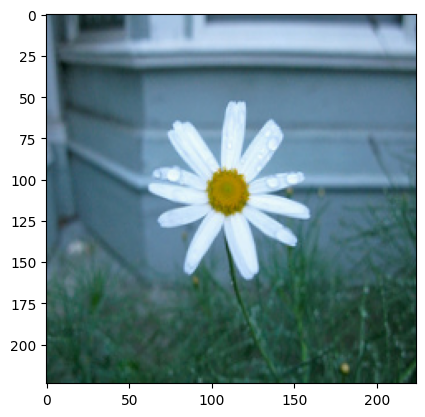

In [52]:
ex_img = cv2.imread("/content/examples/0.png")[...,::-1]
plt.imshow(ex_img)

In [53]:
predict(ex_img)

1/1 [==============================] - 0s 116ms/step


{'dandelion': 6.779297956338581e-11,
 'daisy': 0.9802260398864746,
 'tulips': 4.4577971669658813e-20,
 'sunflowers': 0.01977391541004181,
 'roses': 1.274067916335006e-17}

In [54]:
# declerating the params
component_params = {
    "fn":predict, 
    "inputs":gr.Image(shape=(224, 224)),
    "outputs":gr.Label(num_top_classes=len(labels)),
    "examples":examples_path,
}

# Instantiating example demo app
demo = gr.Interface(**component_params)

In [55]:
# launching the demo
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>